<a href="https://colab.research.google.com/github/ramziourari/asl-recognition/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Load

In [6]:
! pip install geopandas pandas shapely fiona rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.8 MB/s eta 0:00:00


In [7]:
import geopandas as gpd
import pandas as pd
from shapely import box
import fiona
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import rasterio
import matplotlib.pyplot as plt

In [8]:
def read_gpkg_layers_combined(gpkg_path, layer_names):
    """
    Read multiple layers and combine them into a single GeoDataFrame with a 'layer' column

    Args:
        gpkg_path (str): Path to the GeoPackage file
        layer_names (list): List of layer names to read

    Returns:
        GeoDataFrame: Combined GeoDataFrame with all layers
    """
    # Read each layer and add layer name as a column
    gdfs = []
    for layer in layer_names:
        try:
            gdf = gpd.read_file(gpkg_path, layer=layer)
            gdf['layer'] = layer  # Add layer name as a column
            gdfs.append(gdf)
            print(f"Successfully loaded layer: {layer}")
        except Exception as e:
            print(f"Error loading layer {layer}: {str(e)}")

    # Combine all layers into one GeoDataFrame
    combined_gdf = pd.concat(gdfs, ignore_index=True)
    return combined_gdf

In [14]:
STADT = "Stendal"
prefix = "mgb1"
gpkg_path = f"/content/drive/MyDrive/data/{STADT}/Raw_Data.gpkg"
layers = fiona.listlayers(gpkg_path)
print("Available layers:")
for layer in layers:
    print(f"- {layer}")

Available layers:
- PLANGEBIET
- LAGEPLAENE
- MP_HU
- MP_FG
- ALKIS_HU
- ALKIS_ADRESSE
- ALKIS_FLUR
- MP_TRASSEN
- MP_APL


In [15]:
layers = ["LAGEPLAENE", "ALKIS_HU", "ALKIS_FLUR"]
# Read all layers into a single GeoDataFrame
stadt_df = read_gpkg_layers_combined(gpkg_path, layers)
lp = stadt_df[stadt_df['layer'] == 'LAGEPLAENE']
flur = stadt_df[stadt_df['layer'] == 'ALKIS_FLUR']
haus = stadt_df[stadt_df['layer'] == 'ALKIS_HU']

Successfully loaded layer: LAGEPLAENE
Successfully loaded layer: ALKIS_HU
Successfully loaded layer: ALKIS_FLUR


<Axes: >

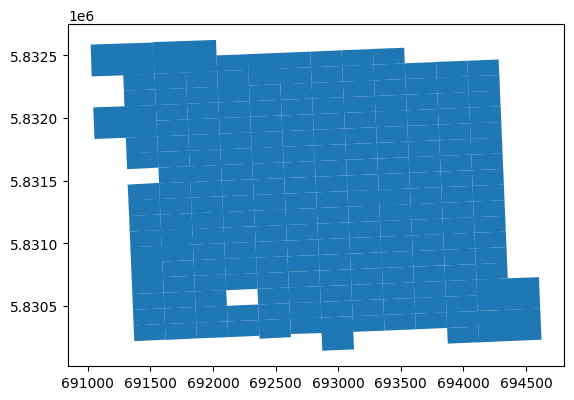

In [16]:
lp.plot()

<Axes: >

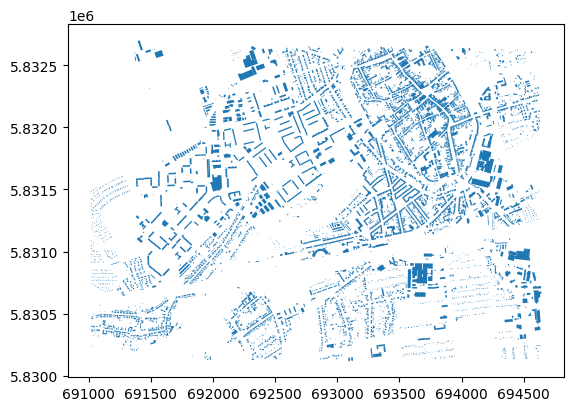

In [17]:
haus.plot()

<Axes: >

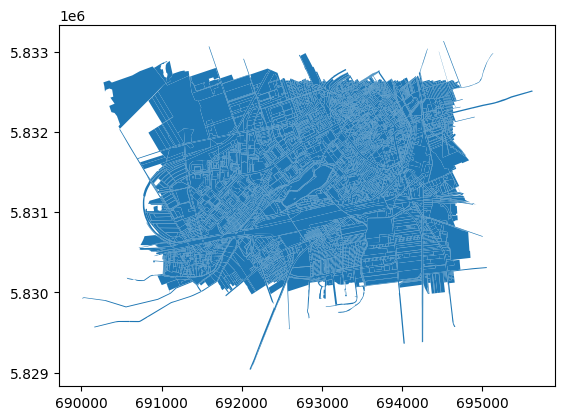

In [18]:
flur.plot()

In [19]:
def get_affine_transformation(tfw_string):
    """Create affine transformation from TFW parameters in pipe-separated string format."""
    tfw_params = [float(x) for x in tfw_string.split('|')]
    xoffset, px_w, rot1, yoffset, rot2, px_h = tfw_params
    geotransform = (xoffset, px_w, rot1, yoffset, rot2, px_h)
    return Affine.from_gdal(*geotransform)

# Create a new column for affine transformation
stadt_df['affine_transform'] = None

# Apply transformation only to LAGEPLAENE rows
mask = stadt_df['layer'] == 'LAGEPLAENE'
stadt_df.loc[mask, 'affine_transform'] = stadt_df.loc[mask, 'TFW'].apply(get_affine_transformation)

# Verify
print("Number of affine transforms created:", stadt_df['affine_transform'].notna().sum())
print("\nExample of first LAGEPLAENE transform:")
print(stadt_df[stadt_df['layer'] == 'LAGEPLAENE']['affine_transform'].iloc[0])

Number of affine transforms created: 211

Example of first LAGEPLAENE transform:
| 0.03, 0.00, 691345.47|
| 0.00,-0.03, 5830844.14|
| 0.00, 0.00, 1.00|


In [22]:
stadt_df.head()

NAME                                                TFW   WIDTH  \
0  mgb1/8828ab  691345.4732|0.0317943251|0.001451167847|583084...  7871.0   
1  mgb1/8828ad  691351.1187|0.03179182459|0.001271360732|58307...  7865.0   
2  mgb1/8828ba  691595.848|0.03177956616|0.001306713676|583085...  7859.0   
3  mgb1/8828bb  691845.0007|0.03177973516|0.001466964258|58308...  7877.0   
4  mgb1/8828bc  691600.9705|0.03178174873|0.001322649449|58307...  7860.0   

   HEIGHT  DATABASE_ID                                           geometry  \
0  4295.0         60.0  POLYGON ((691345.473 5830844.137, 691595.726 5...   
1  3970.0         60.0  POLYGON ((691351.119 5830719.339, 691601.161 5...   
2  3965.0         60.0  POLYGON ((691595.848 5830854.41, 691845.604 58...   
3  4008.0         60.0  POLYGON ((691845.001 5830864.799, 692095.33 58...   
4  3975.0         60.0  POLYGON ((691600.971 5830729.514, 691850.775 5...   

        layer FUNKTION HU_ID Nutzung Objektart  \
0  LAGEPLAENE      NaN   NaN     NaN       NaN   
1  LAGEPLAENE      NaN   NaN     NaN       NaN   
2  LAGEPLAENE      NaN   NaN     NaN       NaN   
3  LAGEPLAENE      NaN   NaN     NaN       NaN   
4  LAGEPLAENE      NaN   NaN     NaN       NaN   

                                    affine_transform  
0  (0.0317943251, 0.001451167847, 691345.4732, 0....  
1  (0.03179182459, 0.001271360732, 691351.1187, 0...  
2  (0.03177956616, 0.001306713676, 691595.848, 0....  
3  (0.03177973516, 0.001466964258, 691845.0007, 0...  
4  (0.03178174873, 0.001322649449, 691600.9705, 0...

In [21]:
# Get LAGEPLAN info once
lageplan_row = stadt_df[stadt_df['layer'] == 'LAGEPLAENE'].iloc[0]
lageplan_polygon = lageplan_row.geometry
lageplan_name = lageplan_row['NAME']
tif_id = lageplan_name.split('kblz1/')[1]
bounds = lageplan_polygon.bounds

# Filter intersecting features once
intersecting_hu = stadt_df[
    (stadt_df['layer'].isin(['ALKIS_HU', 'ALKIS_FLUR'])) &
    (stadt_df.geometry.intersects(lageplan_polygon))
]

# Common plot settings
def setup_plot(fig, ax):
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    plt.tight_layout(pad=0)

# 1. TIF only
fig1, ax1 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=300)
with rasterio.open(f"../data/Trier/Raster/{tif_id}.tif") as src:
    image = src.read(1)
    ax1.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
setup_plot(fig1, ax1)
plt.show()

# 2. Vector data only
fig2, ax2 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=300)
intersecting_hu.plot(ax=ax2,
                    facecolor='none',
                    edgecolor='#00A6A6',  # Teal color
                    linewidth=0.8)
setup_plot(fig2, ax2)
plt.show()

# 3. Combined overlay
fig3, ax3 = plt.subplots(figsize=(15, 10), facecolor='white', dpi=300)
with rasterio.open(f"../data/Trier/Raster/{tif_id}.tif") as src:
    image = src.read(1)
    ax3.imshow(image,
              extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
              cmap='gray_r',
              interpolation='nearest')
intersecting_hu.plot(ax=ax3,
                    facecolor='none',
                    edgecolor='#00A6A6',  # Teal color
                    linewidth=0.8)
setup_plot(fig3, ax3)
plt.show()

print(f"TIF file: {tif_id}.tif")
print(f"Number of intersecting features: {len(intersecting_hu)}")

IndexError: list index out of range

In [2]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


/content/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint", filter_threshold=0.1).eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

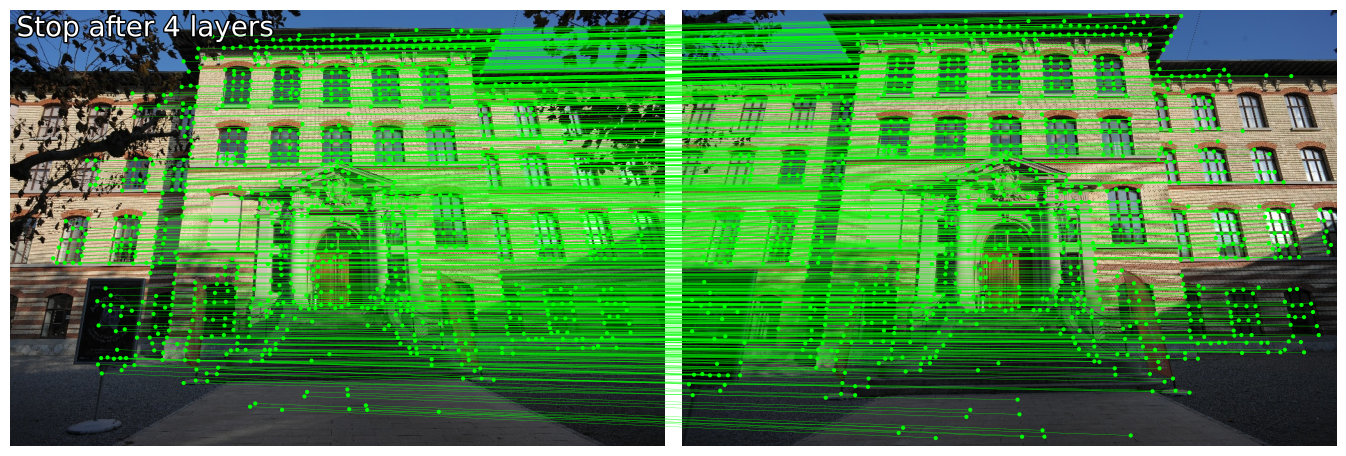

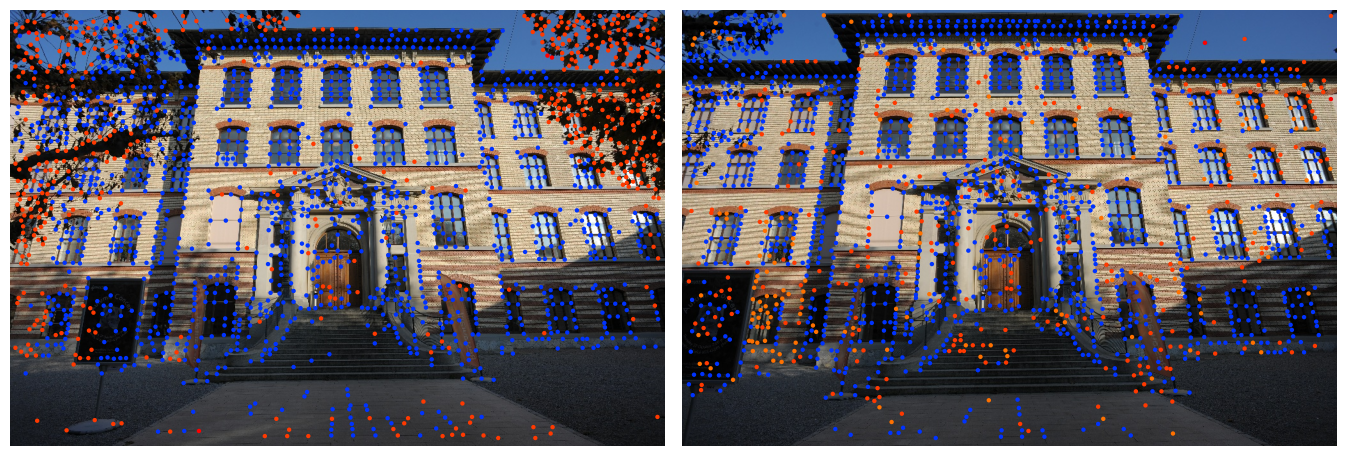

In [5]:
image0 = load_image(images / "DSC_0411.JPG")
image1 = load_image(images / "DSC_0410.JPG")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

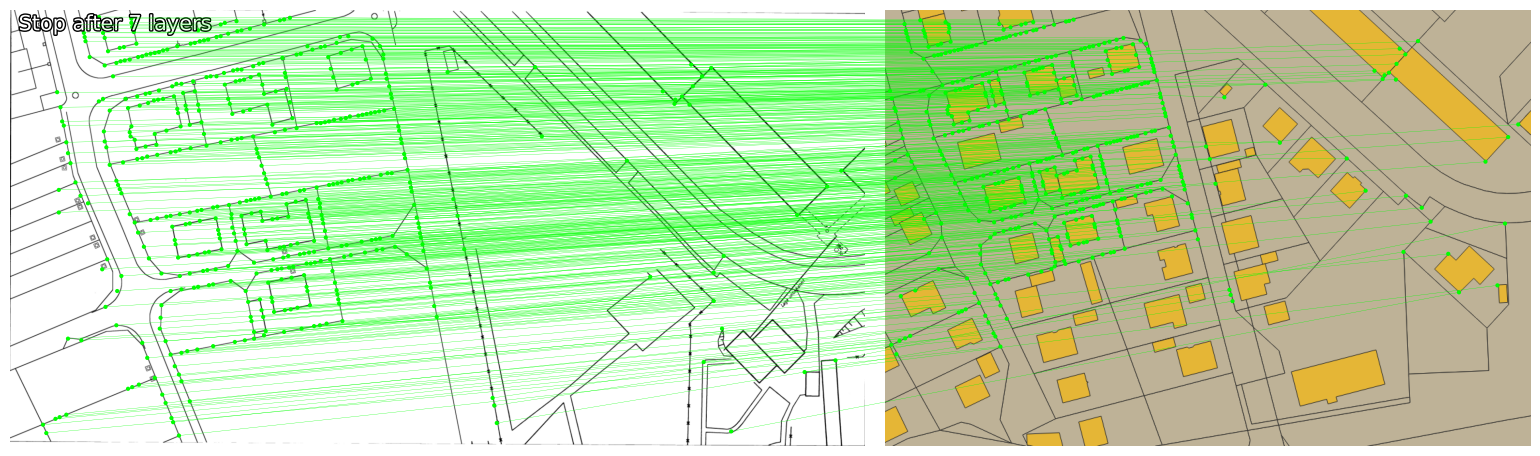

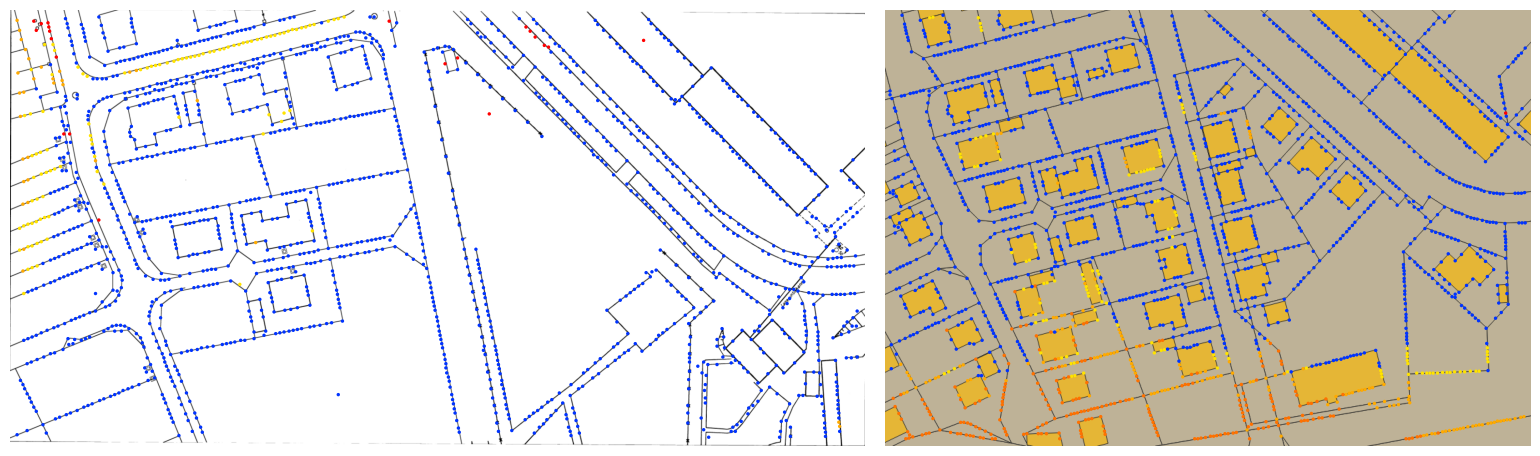

In [42]:
image0 = load_image(images / "8828ab_raster.png")
image1 = load_image(images / "8828ab_qgis.png")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

Mean shift: dx=-308.6, dy=-179.5 pixels


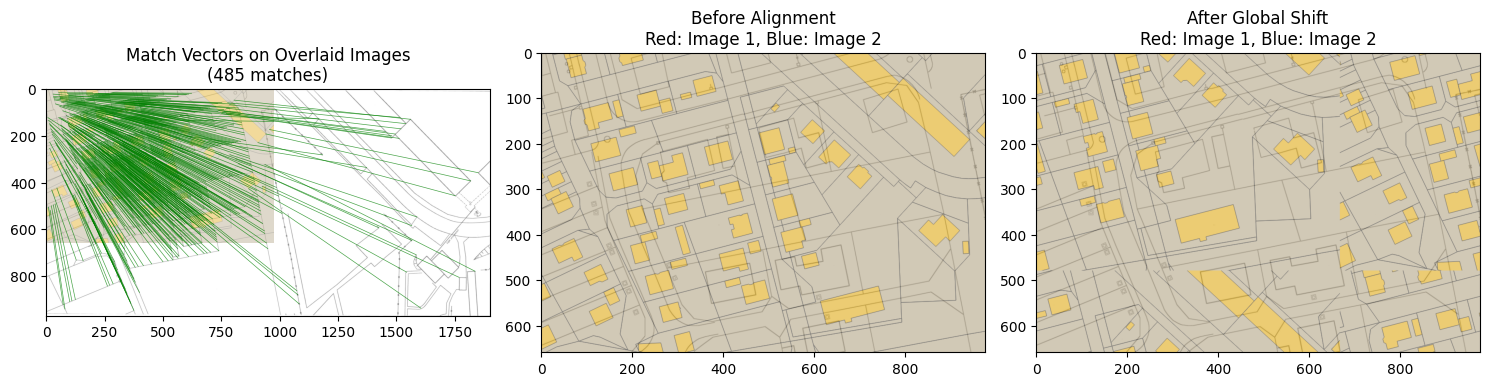


Shift statistics:
Average magnitude: 373.7 pixels
Max magnitude: 1010.1 pixels
Min magnitude: 114.3 pixels


In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create visualization
plt.figure(figsize=(15, 5))

# Convert images
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# 1. Matches with overlaid images
plt.subplot(131)
plt.imshow(image0_np, cmap='gray', alpha=0.5)
plt.imshow(image1_np, cmap='gray', alpha=0.5)

# Draw vectors between matches on overlaid images
for p1, p2 in zip(m_kpts0_np, m_kpts1_np):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'g-', linewidth=0.5, alpha=0.7)

plt.title(f'Match Vectors on Overlaid Images\n({len(m_kpts0_np)} matches)')

# 2. Overlay before alignment
plt.subplot(132)
plt.imshow(image0_np, cmap='Reds', alpha=0.7)
plt.imshow(image1_np, cmap='Blues', alpha=0.7)
plt.title('Before Alignment\nRed: Image 1, Blue: Image 2')

# 3. Overlay after global shift
plt.subplot(133)
mean_shift = np.mean(m_kpts1_np - m_kpts0_np, axis=0)
print(f"Mean shift: dx={mean_shift[0]:.1f}, dy={mean_shift[1]:.1f} pixels")

shifted_img = np.roll(np.roll(image1_np, int(mean_shift[0]), axis=1), int(mean_shift[1]), axis=0)

plt.imshow(image0_np, cmap='Reds', alpha=0.7)
plt.imshow(shifted_img, cmap='Blues', alpha=0.7)
plt.title('After Global Shift\nRed: Image 1, Blue: Image 2')

plt.tight_layout()
plt.show()

# Print shift statistics
shifts = m_kpts1_np - m_kpts0_np
magnitudes = np.sqrt(np.sum(shifts**2, axis=1))
print("\nShift statistics:")
print(f"Average magnitude: {np.mean(magnitudes):.1f} pixels")
print(f"Max magnitude: {np.max(magnitudes):.1f} pixels")
print(f"Min magnitude: {np.min(magnitudes):.1f} pixels")

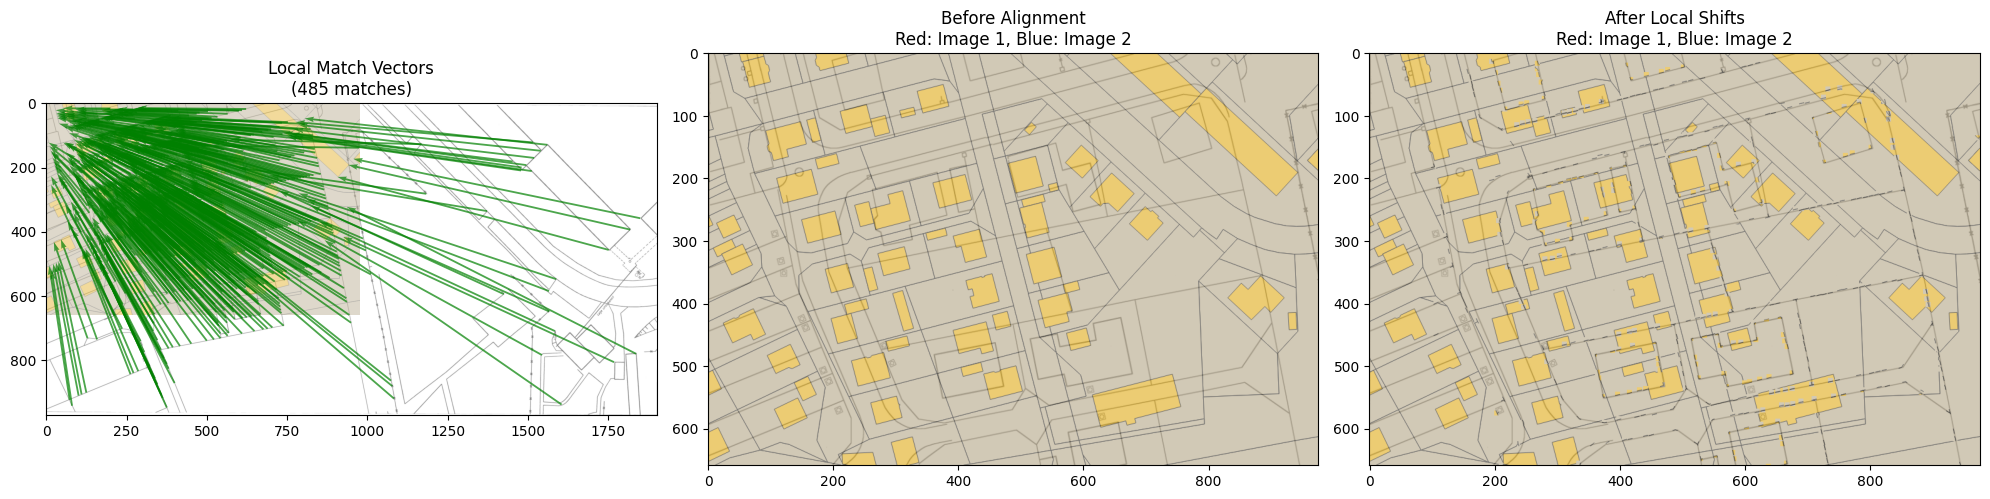


Local shift statistics:
Average magnitude: 373.7 pixels
Max magnitude: 1010.1 pixels
Min magnitude: 114.3 pixels


In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create visualization
plt.figure(figsize=(20, 5))

# Convert images and keypoints
image0_np = image0.cpu().numpy().transpose(1, 2, 0)
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
m_kpts0_np = m_kpts0.cpu().numpy()
m_kpts1_np = m_kpts1.cpu().numpy()

# Calculate shifts
shifts = m_kpts1_np - m_kpts0_np
magnitudes = np.sqrt(np.sum(shifts**2, axis=1))

# 1. Matches with overlaid images
plt.subplot(131)
plt.imshow(image0_np, cmap='gray', alpha=0.5)
plt.imshow(image1_np, cmap='gray', alpha=0.5)

# Draw vectors with arrows using quiver
plt.quiver(m_kpts0_np[:, 0], m_kpts0_np[:, 1],
          shifts[:, 0], shifts[:, 1],
          color='green',
          angles='xy',
          scale_units='xy',
          scale=1,
          width=0.003,
          headwidth=3,
          headlength=5,
          headaxislength=4.5,
          alpha=0.7)

plt.title(f'Local Match Vectors\n({len(m_kpts0_np)} matches)')

# 2. Original overlay
plt.subplot(132)
plt.imshow(image0_np, cmap='Reds', alpha=0.7)
plt.imshow(image1_np, cmap='Blues', alpha=0.7)
plt.title('Before Alignment\nRed: Image 1, Blue: Image 2')

# 3. Apply local shifts
locally_shifted = apply_local_shifts(image1_np, m_kpts1_np, m_kpts0_np, radius=4)

plt.subplot(133)
plt.imshow(image0_np, cmap='Reds', alpha=0.7)
plt.imshow(locally_shifted, cmap='Blues', alpha=0.7)
plt.title('After Local Shifts\nRed: Image 1, Blue: Image 2')

plt.tight_layout()
plt.show()

# Print shift statistics
print("\nLocal shift statistics:")
print(f"Average magnitude: {np.mean(magnitudes):.1f} pixels")
print(f"Max magnitude: {np.max(magnitudes):.1f} pixels")
print(f"Min magnitude: {np.min(magnitudes):.1f} pixels")